In [6]:
!pip install kaggle

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download hassan06/nslkdd/

Dataset URL: https://www.kaggle.com/datasets/hassan06/nslkdd/versions/
License(s): unknown
 58% 8.00M/13.9M [00:00<00:00, 32.9MB/s]
100% 13.9M/13.9M [00:00<00:00, 49.2MB/s]


In [9]:
!unzip nslkdd

Archive:  nslkdd.zip
  inflating: KDDTest+.arff           
  inflating: KDDTest+.txt            
  inflating: KDDTest-21.arff         
  inflating: KDDTest-21.txt          
  inflating: KDDTest1.jpg            
  inflating: KDDTrain+.arff          
  inflating: KDDTrain+.txt           
  inflating: KDDTrain+_20Percent.arff  
  inflating: KDDTrain+_20Percent.txt  
  inflating: KDDTrain1.jpg           
  inflating: index.html              
  inflating: nsl-kdd/KDDTest+.arff   
  inflating: nsl-kdd/KDDTest+.txt    
  inflating: nsl-kdd/KDDTest-21.arff  
  inflating: nsl-kdd/KDDTest-21.txt  
  inflating: nsl-kdd/KDDTest1.jpg    
  inflating: nsl-kdd/KDDTrain+.arff  
  inflating: nsl-kdd/KDDTrain+.txt   
  inflating: nsl-kdd/KDDTrain+_20Percent.arff  
  inflating: nsl-kdd/KDDTrain+_20Percent.txt  
  inflating: nsl-kdd/KDDTrain1.jpg   
  inflating: nsl-kdd/index.html      


In [3]:
# from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
!pip install -q keras
from keras.utils import to_categorical
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#train+, test+ and test21- dataset loading
train='/content/nsl-kdd/KDDTrain+.txt'
test='/content/nsl-kdd/KDDTest+.txt'
test21='/content/nsl-kdd/KDDTest-21.txt'

featureV=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

flagV=['OTH','RSTOS0','SF','SH','RSTO','S2','S1','REJ','S3','RSTR','S0']

protocol_typeV=['tcp','udp','icmp']

serviceV=['http','smtp','finger','domain_u','auth','telnet','ftp','eco_i','ntp_u','ecr_i','other','private','pop_3','ftp_data',
                  'rje','time','mtp','link','remote_job','gopher','ssh','name','whois','domain','login','imap4','daytime','ctf','nntp',
                  'shell','IRC','nnsp','http_443','exec','printer','efs','courier','uucp','klogin','kshell','echo','discard','systat',
                  'supdup','iso_tsap','hostnames','csnet_ns','pop_2','sunrpc','uucp_path','netbios_ns','netbios_ssn','netbios_dgm',
                  'sql_net','vmnet','bgp','Z39_50','ldap','netstat','urh_i','X11','urp_i','pm_dump','tftp_u','tim_i','red_i','icmp',
                  'http_2784','harvest','aol','http_8001']

binary_attack=['normal','ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan','back', 'land', 'neptune', 'pod', 'smurf',
               'teardrop', 'apache2', 'udpstorm', 'processtable','mailbomb','buffer_overflow', 'loadmodule', 'perl', 'rootkit',
               'xterm', 'ps', 'sqlattack','ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy', 'warezclient',
               'warezmaster','snmpgetattack','named', 'xlock', 'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']

multiclass_attack={ 'normal': 'normal',
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'],
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'],
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'],
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.',
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}

In [12]:
train

'/content/nsl-kdd/KDDTrain+.txt'

In [13]:
train_data=pd.read_csv(train,names=featureV)
test_data=pd.read_csv(test,names=featureV)

In [14]:
test_21 = pd.read_csv(test21, names= featureV)

In [15]:
#this code filter out the specific service types form both the training and tesstion dataset, eg : the first line remove the instance form the training dataset where the service is "a;lo " and same for the other 
train_data = train_data.query("service != 'aol'")
train_data = train_data.query("service != 'harvest'")
train_data = train_data.query("service != 'http_2784'")
train_data = train_data.query("service != 'http_8001'")
train_data = train_data.query("service != 'red_i'")
train_data = train_data.query("service != 'urh_i'")
train_data = train_data.query("service != 'printer'")
train_data = train_data.query("service != 'rje'")


#-------------------------------------------------------------------------------->>>>

test_data = test_data.query("service != 'printer'")
test_data = test_data.query("service != 'rje'")

In [16]:
def bar_graph(feature):
    train_data[feature].value_counts().plot(kind="bar")

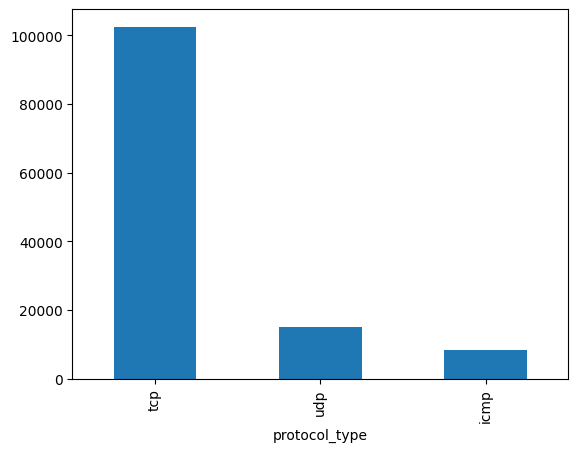

In [17]:
bar_graph('protocol_type')

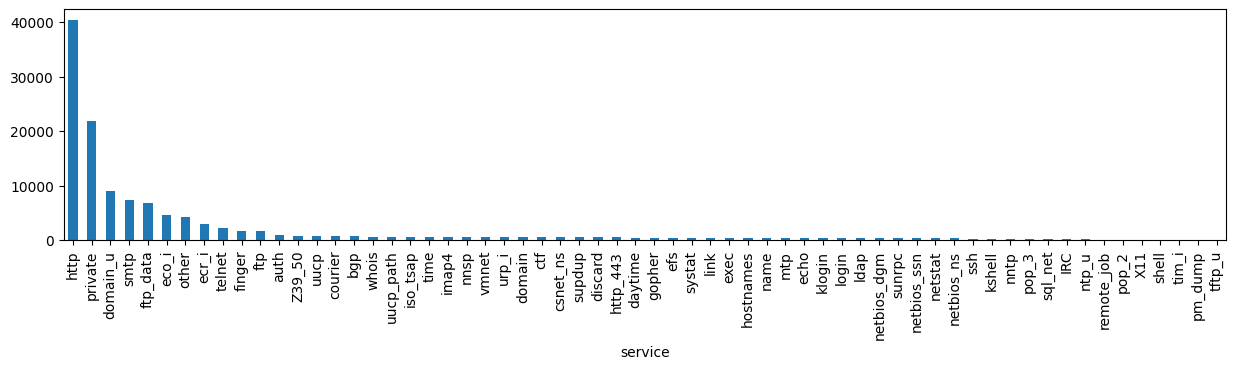

In [18]:
plt.figure(figsize=(15,3))
bar_graph('service')

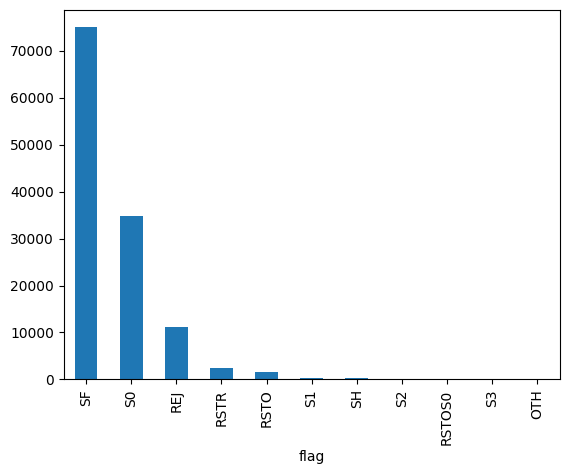

In [19]:
bar_graph('flag')

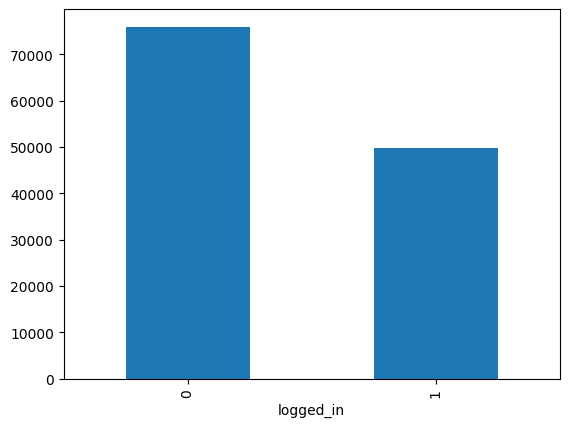

In [20]:
bar_graph('logged_in')

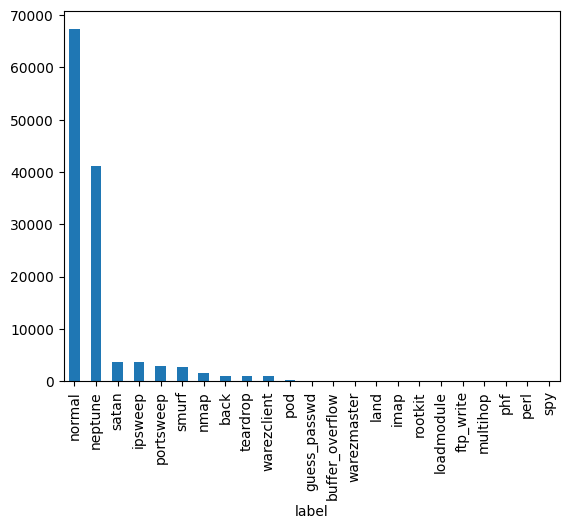

In [21]:
bar_graph('label')

In [22]:
def preprocessing(data,cls,df):

#----------attack categorization----------------->
  data['label']=data['label'].replace(['normal.','normal'],0)

#----------------------binary classification--------------------->
  if cls=='binary':
    for i in range(len(binary_attack)):
      data['label'] = data['label'].replace(binary_attack[i], 1)

#---------------multiclass classification-------------------->
  elif cls=='multiclass':
    for i in range(len(multiclass_attack['probe'])):
      data['label']=data['label'].replace([multiclass_attack['probe'][i],multiclass_attack['probe'][i][:-1]],1)

    for i in range(len(multiclass_attack['dos'])):
      data['label']=data['label'].replace([multiclass_attack['dos'][i],multiclass_attack['dos'][i][:-1]],2)

    for i in range(len(multiclass_attack['u2r'])):
      data['label']=data['label'].replace([multiclass_attack['u2r'][i],multiclass_attack['u2r'][i][:-1]],3)

    for i in range(len(multiclass_attack['r2l'])):
      data['label'] = data['label'].replace([multiclass_attack['r2l'][i],multiclass_attack['r2l'][i][:-1]],4)
#------------------------------------------------>


#-------------------------splitting features and labels---------------->
  y=data['label']
  x=data.loc[:,'duration':'hot']
#---------------------------------------------------------------------->


#-----------------------------------converting string objects to int------------------------>
  #for i in range(len(protocol_typeV)):
   # x['protocol_type'] = x['protocol_type'].replace(protocol_typeV[i], i)

  #for i in range(len(serviceV)):
   # x['service'] = x['service'].replace(serviceV[i], i+1)

  #for i in range(len(flagV)):
   # x['flag'] = x['flag'].replace(flagV[i], i+1)
#------------------------------------------------------------------------------------------->

#-----------------converting to binary feature vectors-------------------------------------->
  t=x.protocol_type.copy()
  t=pd.get_dummies(t)
  x=x.drop(columns='protocol_type',axis=1)
  x=x.join(t)

  t1=x.service.copy()
  t1=pd.get_dummies(t1)
  x=x.drop(columns='service',axis=1)
  x=x.join(t1)

  t2=x.flag.copy()
  t2=pd.get_dummies(t2)
  x=x.drop(columns='flag',axis=1)
  x=x.join(t2)
#------------------------------------------------------------------------------>

#-----------------converting to binary label vectors-------------------------------------->
  yt=y.copy()
  yt=pd.get_dummies(yt)
#------------------------------------------------------------------------------>

  x = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)
  # x = MaxAbsScaler().fit_transform(x)
  # x = StandardScaler().fit_transform(x)
  #print(x)
  #vectorizer = CountVectorizer()
  #p= vectorizer.fit_transform(x.protocol_type)

  #print(np.shape(p))
  #scaler = Normalizer(norm='l1').fit(x)
  #trainX = scaler.transform(x)
  if df=='train':
    return x,yt
  else:
    return x,y

In [23]:
x_train,Y_train=preprocessing(train_data,cls='binary',df='train')
x_test,Y_test=preprocessing(test_data,cls='binary',df='test')

In [24]:
x_21_test, y_21_test = preprocessing(test_21, cls = 'binary', df = 'test21')

In [25]:
print(np.shape(x_train))
print(np.shape(Y_train))
print(np.shape(x_test))
print(np.shape(Y_test))
print(np.shape(x_21_test))
print(np.shape(y_21_test))

(125793, 83)
(125793, 2)
(22525, 83)
(22525,)
(11850, 83)
(11850,)


In [26]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(125793, 83, 1)

In [27]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(22525, 83, 1)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU, Activation, BatchNormalization, Conv1D, Flatten, MaxPooling1D, AveragePooling1D
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D , AveragePooling1D


In [ ]:
model = Sequential()

model.add(Convolution1D(32, 3, padding="same",activation="relu",input_shape = (x_train.shape[1], 1)))
# model.add(Convolution1D(32, 3, activation="relu"))
model.add(MaxPooling1D(pool_size=(4)))
# model.add(tf.keras.layers.LayerNormalization())
# model.add(GRU(units = 128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.5))

model.add(Convolution1D(64, 3, padding="same",activation="relu"))
# model.add(Convolution1D(64, 3,activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))
# model.add(tf.keras.layers.LayerNormalization())

# model.add(Convolution1D(64, 3, padding="same",activation="relu"))
# model.add(Convolution1D(64, 3,activation="relu"))
# model.add(AveragePooling1D(pool_size=(2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
#10 layers are used in this section

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [31]:
# tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# train_op = tf.keras.optimizers.adam(amsgrad=True)
model.compile(optimizer ='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(x_train, Y_train, epochs = 100, batch_size = 128)

Epoch 1/100
983/983 [==============================] - 10s 5ms/step - loss: 0.1814 - accuracy: 0.9399
Epoch 2/100
983/983 [==============================] - 4s 4ms/step - loss: 0.1517 - accuracy: 0.9519
Epoch 3/100
983/983 [==============================] - 4s 4ms/step - loss: 0.1461 - accuracy: 0.9538
Epoch 4/100
983/983 [==============================] - 4s 4ms/step - loss: 0.1430 - accuracy: 0.9543
Epoch 5/100
983/983 [==============================] - 5s 5ms/step - loss: 0.1401 - accuracy: 0.9548
Epoch 6/100
983/983 [==============================] - 4s 4ms/step - loss: 0.1365 - accuracy: 0.9551
Epoch 7/100
983/983 [==============================] - 6s 6ms/step - loss: 0.1311 - accuracy: 0.9551
Epoch 8/100
983/983 [==============================] - 5s 5ms/step - loss: 0.1285 - accuracy: 0.9555
Epoch 9/100
983/983 [==============================] - 4s 4ms/step - loss: 0.1277 - accuracy: 0.9551
Epoch 10/100
983/983 [==============================] - 4s 4ms/step - loss: 0.1269 - accur

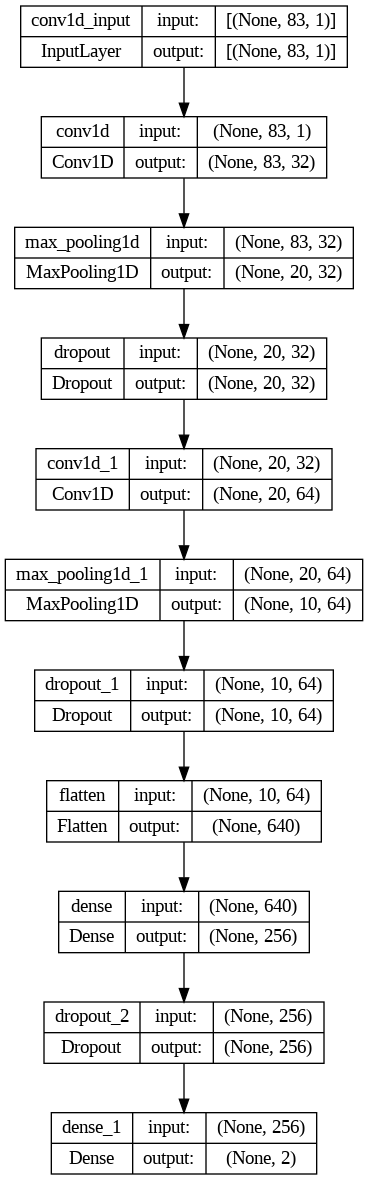

In [39]:
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [40]:
pred = model.predict(x_test)
y_pred= np.argmax(pred, axis = 1)

704/704 [==============================] - 1s 2ms/step


In [41]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

In [42]:
confusion_matrix(Y_test, y_pred)

array([[8727,  984],
       [2892, 9922]])

In [43]:
accuracy =accuracy_score(Y_test, y_pred)*100
print(accuracy)

82.79245283018868


In [44]:
print(y_pred)
print(len(y_pred))

[1 1 0 ... 0 0 1]
22525


In [45]:
print(y_21_test)

0        1
1        1
2        1
3        0
4        1
        ..
11845    0
11846    0
11847    1
11848    1
11849    1
Name: label, Length: 11850, dtype: int64


In [46]:
print(x_21_test)
print(len(x_21_test))

[[2.25244737e-04 1.87821381e-06 1.88181138e-03 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.00350914e-07 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.41442065e-05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.73265182e-05 0.00000000e+00 1.16400704e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.52599715e-07 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]
11850


In [47]:
# Assuming x_21_test is a numpy array
# Reshape x_21_test to match model's input shape
x_21_test_reshaped = x_21_test.reshape(x_21_test.shape[0], x_21_test.shape[1], 1)


In [48]:
# Predict with reshaped test data
pred = model.predict(x_21_test_reshaped)
y_pred = np.argmax(pred, axis=1)


371/371 [==============================] - 1s 2ms/step


In [49]:
# pred = model.predict(x_21_test)
# y_pred= np.argmax(pred, axis = 1)

In [50]:
confusion_matrix(y_21_test, y_pred)

array([[1209,  943],
       [2892, 6806]])

In [51]:
print(y_pred)

[0 1 1 ... 1 1 1]


In [52]:
acc_21 = accuracy_score(y_21_test, y_pred)* 100
print(acc_21)

67.63713080168776


In [53]:
recall = recall_score(y_21_test, y_pred , average="binary")
precision = precision_score(y_21_test, y_pred , average="binary")
f1 = f1_score(y_21_test, y_pred, average="binary")

In [54]:
  print("accuracy")
  print("%.3f" %acc_21)
  print("racall")
  print("%.3f" %recall)
  print("precision")
  print("%.3f" %precision)
  print("f1score")
  print(f1)

accuracy
67.637
racall
0.702
precision
0.878
f1score
0.7801914369232532


In [55]:
print("F-Score : ", f1*100)
print("Precision : " , precision*100)
print("Recall : ", recall*100)
print("Accuracy : ",acc_21)

F-Score :  78.01914369232531
Precision :  87.83068783068782
Recall :  70.17941843679108
Accuracy :  67.63713080168776


dense


In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Define Dense Neural Network model
model_dense = Sequential()
model_dense.add(Dense(256, input_shape=(x_train.shape[1],), activation='relu'))  # Dense layer with ReLU activation
model_dense.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model_dense.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model_dense.add(Dense(2, activation='softmax'))  # Output layer with softmax activation for binary classification

In [64]:
# Compile Dense Neural Network model
model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display Dense Neural Network model architecture
model_dense.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               21504     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 54658 (213.51 KB)
Trainable params: 54658 (213.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# Train Dense Neural Network model
history_dense = model_dense.fit(x_train, Y_train, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
787/787 [==============================] - 6s 6ms/step - loss: 0.1339 - accuracy: 0.9574 - val_loss: 0.1135 - val_accuracy: 0.9637
Epoch 2/100
787/787 [==============================] - 3s 4ms/step - loss: 0.1158 - accuracy: 0.9617 - val_loss: 0.1089 - val_accuracy: 0.9607
Epoch 3/100
787/787 [==============================] - 4s 5ms/step - loss: 0.1073 - accuracy: 0.9623 - val_loss: 0.0950 - val_accuracy: 0.9607
Epoch 4/100
787/787 [==============================] - 3s 4ms/step - loss: 0.0924 - accuracy: 0.9654 - val_loss: 0.0834 - val_accuracy: 0.9696
Epoch 5/100
787/787 [==============================] - 4s 5ms/step - loss: 0.0878 - accuracy: 0.9684 - val_loss: 0.0816 - val_accuracy: 0.9698
Epoch 6/100
787/787 [==============================] - 3s 4ms/step - loss: 0.0858 - accuracy: 0.9692 - val_loss: 0.0807 - val_accuracy: 0.9676
Epoch 7/100
787/787 [==============================] - 3s 4ms/step - loss: 0.0851 - accuracy: 0.9694 - val_loss: 0.0811 - val_accuracy: 0.9700

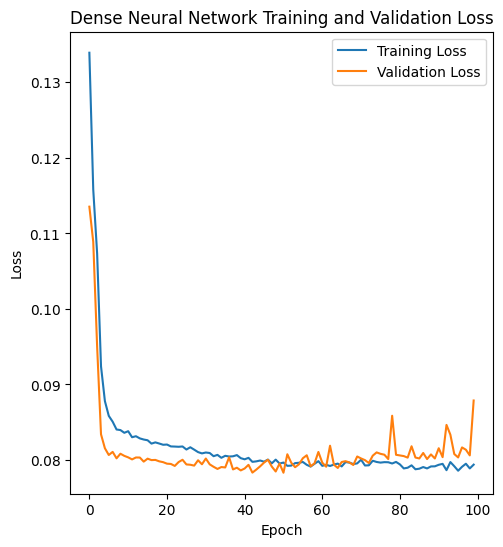

In [66]:
# Plot training history of Dense Neural Network model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history['loss'], label='Training Loss')
plt.plot(history_dense.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dense Neural Network Training and Validation Loss')
plt.legend()


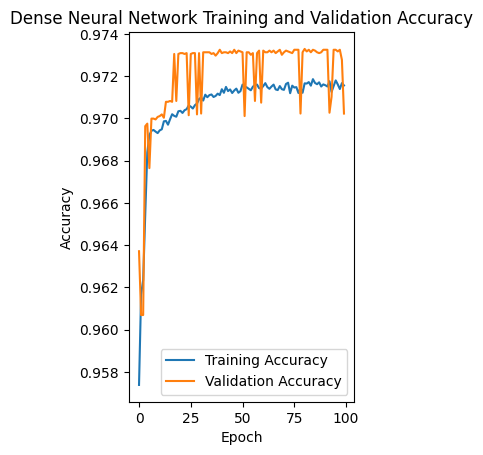

In [67]:

plt.subplot(1, 2, 2)
plt.plot(history_dense.history['accuracy'], label='Training Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Dense Neural Network Training and Validation Accuracy')
plt.legend()
plt.show()

In [68]:

# Predict using Dense Neural Network model
pred_dense = model_dense.predict(x_test)
y_pred_dense = np.argmax(pred_dense, axis=1)

704/704 [==============================] - 1s 1ms/step


In [69]:
# Evaluate Dense Neural Network model
accuracy_dense = accuracy_score(Y_test, y_pred_dense) * 100
recall_dense = recall_score(Y_test, y_pred_dense, average='binary')
precision_dense = precision_score(Y_test, y_pred_dense, average='binary')
f1_dense = f1_score(Y_test, y_pred_dense, average='binary')

In [70]:
# Display evaluation metrics of Dense Neural Network model
print("Dense Neural Network Model Evaluation:")
print(f"Accuracy: {accuracy_dense:.3f}")
print(f"Recall: {recall_dense:.3f}")
print(f"Precision: {precision_dense:.3f}")
print(f"F1 Score: {f1_dense:.3f}")

Dense Neural Network Model Evaluation:
Accuracy: 80.817
Recall: 0.738
Precision: 0.908
F1 Score: 0.814


In [4]:
# Confusion Matrix of Dense Neural Network model
cm_dense = confusion_matrix(Y_test.argmax(axis=1), y_pred_dense)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Dense Neural Network)')
plt.show()

cnn


In [72]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define Convolutional Neural Network model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))  # Convolutional layer with ReLU activation
model_cnn.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model_cnn.add(Conv1D(32, kernel_size=3, activation='relu'))  # Convolutional layer with ReLU activation
model_cnn.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model_cnn.add(Flatten())  # Flatten layer to prepare for dense layers
model_cnn.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model_cnn.add(Dense(2, activation='softmax'))  # Output layer with softmax activation for binary classification

In [73]:

# Compile Convolutional Neural Network model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display Convolutional Neural Network model architecture
model_cnn.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 81, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 40, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 38, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 608)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [74]:
# Reshape input data for CNN (assuming x_train and x_test are 2D arrays)
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [75]:
# Train Convolutional Neural Network model
history_cnn = model_cnn.fit(x_train_cnn, Y_train, epochs=100, batch_size=128, validation_split=0.2)


Epoch 1/100
787/787 [==============================] - 7s 5ms/step - loss: 0.1392 - accuracy: 0.9566 - val_loss: 0.1176 - val_accuracy: 0.9624
Epoch 2/100
787/787 [==============================] - 4s 5ms/step - loss: 0.1200 - accuracy: 0.9613 - val_loss: 0.1150 - val_accuracy: 0.9634
Epoch 3/100
787/787 [==============================] - 4s 5ms/step - loss: 0.1132 - accuracy: 0.9616 - val_loss: 0.1026 - val_accuracy: 0.9633
Epoch 4/100
787/787 [==============================] - 4s 6ms/step - loss: 0.0934 - accuracy: 0.9658 - val_loss: 0.0874 - val_accuracy: 0.9695
Epoch 5/100
787/787 [==============================] - 3s 4ms/step - loss: 0.0890 - accuracy: 0.9677 - val_loss: 0.0866 - val_accuracy: 0.9663
Epoch 6/100
787/787 [==============================] - 3s 4ms/step - loss: 0.0875 - accuracy: 0.9681 - val_loss: 0.0852 - val_accuracy: 0.9675
Epoch 7/100
787/787 [==============================] - 4s 6ms/step - loss: 0.0868 - accuracy: 0.9680 - val_loss: 0.0875 - val_accuracy: 0.9701

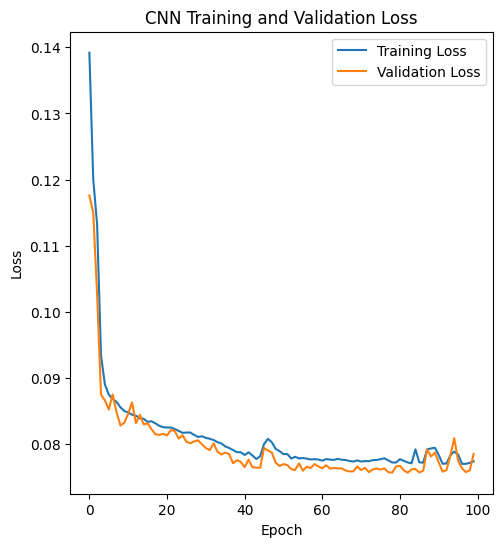

In [76]:
# Plot training history of Convolutional Neural Network model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()

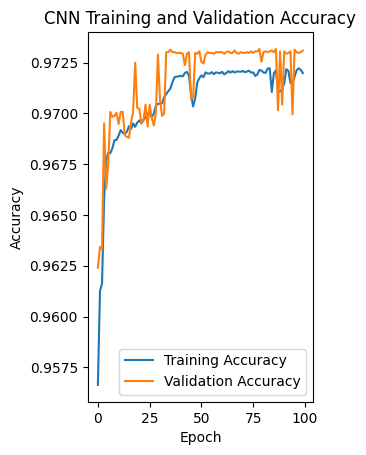

In [77]:
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.show()

In [79]:
 #Predict using Convolutional Neural Network model
pred_cnn = model_cnn.predict(x_test_cnn)
y_pred_cnn = np.argmax(pred_cnn, axis=1)


704/704 [==============================] - 2s 2ms/step


In [80]:

# Evaluate Convolutional Neural Network model
accuracy_cnn = accuracy_score(Y_test, y_pred_cnn) * 100
recall_cnn = recall_score(Y_test, y_pred_cnn, average='binary')
precision_cnn = precision_score(Y_test, y_pred_cnn, average='binary')
f1_cnn = f1_score(Y_test, y_pred_cnn, average='binary')


In [81]:

# Display evaluation metrics of Convolutional Neural Network model
print("Convolutional Neural Network Model Evaluation:")
print(f"Accuracy: {accuracy_cnn:.3f}")
print(f"Recall: {recall_cnn:.3f}")
print(f"Precision: {precision_cnn:.3f}")
print(f"F1 Score: {f1_cnn:.3f}")

Convolutional Neural Network Model Evaluation:
Accuracy: 77.447
Recall: 0.678
Precision: 0.901
F1 Score: 0.774


lstm

In [82]:
from tensorflow.keras.layers import LSTM

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(x_train.shape[1], 1)))  # LSTM layer with 64 units
model_lstm.add(Dense(32, activation='relu'))  # Dense layer with ReLU activation
model_lstm.add(Dense(2, activation='softmax'))  # Output layer with softmax activation for binary classification

In [83]:
# Compile LSTM model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display LSTM model architecture
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 19042 (74.38 KB)
Trainable params: 19042 (74.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
# Reshape input data for LSTM (assuming x_train and x_test are 2D arrays)
x_train_lstm = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_lstm = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [85]:
# Train LSTM model
history_lstm = model_lstm.fit(x_train_lstm, Y_train, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
787/787 [==============================] - 10s 9ms/step - loss: 0.2203 - accuracy: 0.9237 - val_loss: 0.1704 - val_accuracy: 0.9533
Epoch 2/100
787/787 [==============================] - 6s 8ms/step - loss: 0.1623 - accuracy: 0.9488 - val_loss: 0.1556 - val_accuracy: 0.9564
Epoch 3/100
787/787 [==============================] - 5s 7ms/step - loss: 0.1548 - accuracy: 0.9504 - val_loss: 0.1430 - val_accuracy: 0.9530
Epoch 4/100
787/787 [==============================] - 6s 8ms/step - loss: 0.1458 - accuracy: 0.9538 - val_loss: 0.1339 - val_accuracy: 0.9596
Epoch 5/100
787/787 [==============================] - 5s 7ms/step - loss: 0.1405 - accuracy: 0.9551 - val_loss: 0.1364 - val_accuracy: 0.9579
Epoch 6/100
787/787 [==============================] - 6s 8ms/step - loss: 0.1395 - accuracy: 0.9558 - val_loss: 0.1275 - val_accuracy: 0.9608
Epoch 7/100
787/787 [==============================] - 5s 7ms/step - loss: 0.1293 - accuracy: 0.9588 - val_loss: 0.1270 - val_accuracy: 0.960

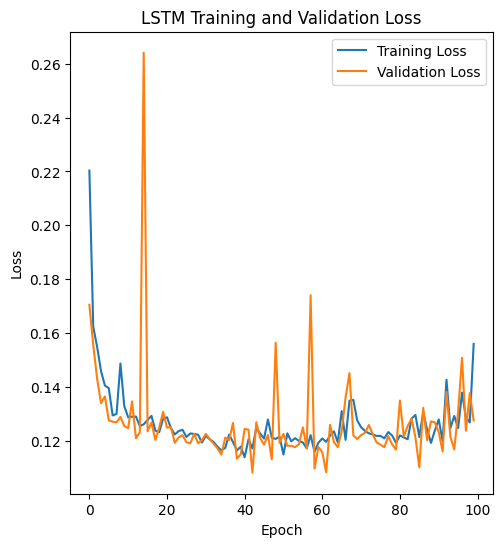

In [86]:
# Plot training history of LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

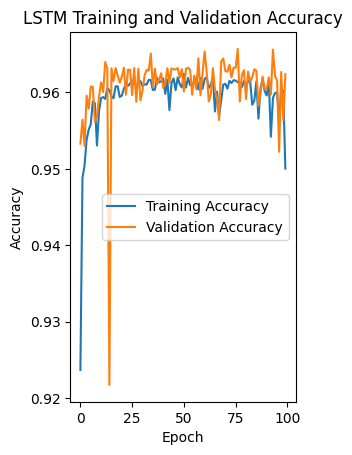

In [87]:
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()
plt.show()

In [89]:
# Predict using LSTM model
pred_lstm = model_lstm.predict(x_test_lstm)
y_pred_lstm = np.argmax(pred_lstm, axis=1)

# Evaluate LSTM model
accuracy_lstm = accuracy_score(Y_test, y_pred_lstm) * 100
recall_lstm = recall_score(Y_test, y_pred_lstm, average='binary')
precision_lstm = precision_score(Y_test, y_pred_lstm, average='binary')
f1_lstm = f1_score(Y_test, y_pred_lstm, average='binary')


704/704 [==============================] - 4s 5ms/step


In [90]:
# Display evaluation metrics of LSTM model
print("LSTM Model Evaluation:")
print(f"Accuracy: {accuracy_lstm:.3f}")
print(f"Recall: {recall_lstm:.3f}")
print(f"Precision: {precision_lstm:.3f}")
print(f"F1 Score: {f1_lstm:.3f}")

LSTM Model Evaluation:
Accuracy: 78.273
Recall: 0.693
Precision: 0.902
F1 Score: 0.784


GRU model

In [91]:
from tensorflow.keras.layers import GRU

# Define GRU model
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(x_train.shape[1], 1)))  # GRU layer with 64 units
model_gru.add(Dense(32, activation='relu'))  # Dense layer with ReLU activation
model_gru.add(Dense(2, activation='softmax'))  # Output layer with softmax activation for binary classification

In [92]:
# Compile GRU model
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display GRU model architecture
model_gru.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 2)                 66        
                                                                 
Total params: 15010 (58.63 KB)
Trainable params: 15010 (58.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
# Reshape input data for GRU (assuming x_train and x_test are 2D arrays)
x_train_gru = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_gru = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [94]:
# Train GRU model
history_gru = model_gru.fit(x_train_gru, Y_train, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
787/787 [==============================] - 45s 7ms/step - loss: 0.2339 - accuracy: 0.9167 - val_loss: 0.1842 - val_accuracy: 0.9520
Epoch 2/100
787/787 [==============================] - 6s 8ms/step - loss: 0.1687 - accuracy: 0.9494 - val_loss: 0.1472 - val_accuracy: 0.9585
Epoch 3/100
787/787 [==============================] - 6s 8ms/step - loss: 0.1559 - accuracy: 0.9524 - val_loss: 0.1366 - val_accuracy: 0.9590
Epoch 4/100
787/787 [==============================] - 5s 7ms/step - loss: 0.1441 - accuracy: 0.9562 - val_loss: 0.1391 - val_accuracy: 0.9577
Epoch 5/100
787/787 [==============================] - 6s 8ms/step - loss: 0.1423 - accuracy: 0.9567 - val_loss: 0.1363 - val_accuracy: 0.9598
Epoch 6/100
787/787 [==============================] - 5s 6ms/step - loss: 0.1362 - accuracy: 0.9585 - val_loss: 0.1310 - val_accuracy: 0.9608
Epoch 7/100
787/787 [==============================] - 6s 7ms/step - loss: 0.1338 - accuracy: 0.9589 - val_loss: 0.1383 - val_accuracy: 0.957

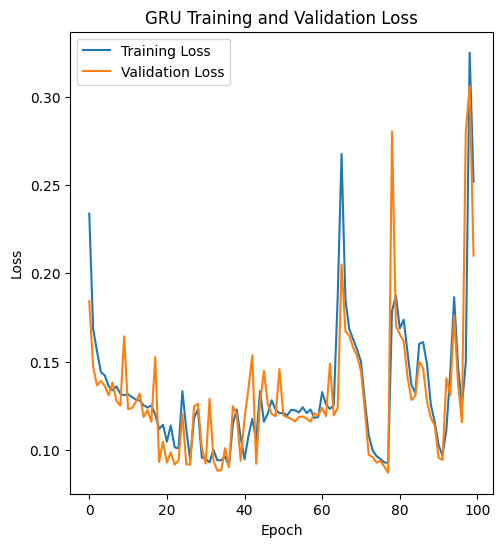

In [95]:
# Plot training history of GRU model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Training and Validation Loss')
plt.legend()

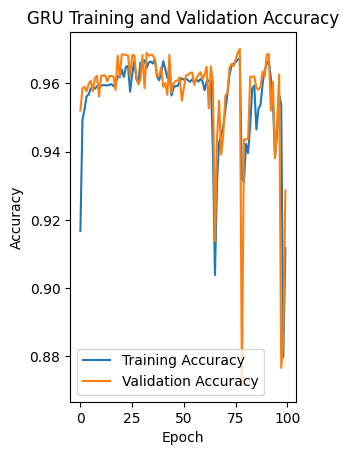

In [96]:
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU Training and Validation Accuracy')
plt.legend()
plt.show()

In [97]:
# Predict using GRU model
pred_gru = model_gru.predict(x_test_gru)
y_pred_gru = np.argmax(pred_gru, axis=1)

# Evaluate GRU model
accuracy_gru = accuracy_score(Y_test, y_pred_gru) * 100
recall_gru = recall_score(Y_test, y_pred_gru, average='binary')
precision_gru = precision_score(Y_test, y_pred_gru, average='binary')
f1_gru = f1_score(Y_test, y_pred_gru, average='binary')

# Display evaluation metrics of GRU model
print("GRU Model Evaluation:")
print(f"Accuracy: {accuracy_gru:.3f}")
print(f"Recall: {recall_gru:.3f}")
print(f"Precision: {precision_gru:.3f}")
print(f"F1 Score: {f1_gru:.3f}")

704/704 [==============================] - 3s 4ms/step
GRU Model Evaluation:
Accuracy: 78.584
Recall: 0.645
Precision: 0.968
F1 Score: 0.774


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', labels=['Normal', 'Intrusion']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix for LSTM model
plot_confusion_matrix(Y_test, y_pred_lstm, title='Confusion Matrix - LSTM Model')

# Plot confusion matrix for GRU model
plot_confusion_matrix(Y_test, y_pred_gru, title='Confusion Matrix - GRU Model')
